In [19]:
!pip install -q yfinance torch torchvision torchaudio scikit-learn matplotlib
!pip install -q transformers accelerate bitsandbytes sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.3 MB/s eta 0:00:00


In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [21]:
ticker = "AAPL"

df = yf.download(ticker, start="2015-01-01", end="2025-01-01")
df = df[['Close']]
df.dropna(inplace=True)

df.head()


/tmp/ipython-input-2159597639.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.237547
2015-01-05,23.554749
2015-01-06,23.556957
2015-01-07,23.887276
2015-01-08,24.805080


In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)


In [22]:
SEQ_LEN = 60

class StockDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.data[idx + self.seq_len]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [23]:
train_size = int(len(scaled_data) * 0.8)

train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - SEQ_LEN:]

train_dataset = StockDataset(train_data, SEQ_LEN)
test_dataset  = StockDataset(test_data, SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [24]:
class TransformerStockModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Linear(1, 128)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128, nhead=8, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.embed(x)
        x = self.transformer(x)
        return self.fc(x[:, -1])


In [32]:
model = TransformerStockModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

EPOCHS = 20

losses = [] # Initialize a list to store losses

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss/len(train_loader)
    losses.append(avg_loss) # Store the average loss for the epoch
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.6f}")

Epoch 1/20 | Loss: 0.035381
Epoch 2/20 | Loss: 0.005370
Epoch 3/20 | Loss: 0.003686
Epoch 4/20 | Loss: 0.002788
Epoch 5/20 | Loss: 0.002375
Epoch 6/20 | Loss: 0.001741
Epoch 7/20 | Loss: 0.001456
Epoch 8/20 | Loss: 0.001309
Epoch 9/20 | Loss: 0.001032
Epoch 10/20 | Loss: 0.001015
Epoch 11/20 | Loss: 0.000946
Epoch 12/20 | Loss: 0.000827
Epoch 13/20 | Loss: 0.000766
Epoch 14/20 | Loss: 0.000692
Epoch 15/20 | Loss: 0.000675
Epoch 16/20 | Loss: 0.000690
Epoch 17/20 | Loss: 0.000633
Epoch 18/20 | Loss: 0.000571
Epoch 19/20 | Loss: 0.000658
Epoch 20/20 | Loss: 0.000519


In [35]:
model.eval()

preds, actuals = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        out = model(x)

        preds.extend(out.cpu().numpy())
        actuals.extend(y.numpy())

preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

mse = mean_squared_error(actuals, preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actuals, preds)

print("MSE :", mse)
print("RMSE:", rmse)
print("MAE :", mae)


MSE : 131.91419982910156
RMSE: 11.485390712949279
MAE : 10.575881958007812


In [36]:
last_sequence = torch.tensor(
    scaled_data[-SEQ_LEN:], dtype=torch.float32
).unsqueeze(0).to(device)

with torch.no_grad():
    next_price_scaled = model(last_sequence).cpu().numpy()

next_price = scaler.inverse_transform(next_price_scaled)[0][0]
last_price = df['Close'].iloc[-1]

print("Last Price:", last_price)
print("Predicted Next Price:", next_price)


Last Price: Ticker
AAPL    249.292511
Name: 2024-12-31 00:00:00, dtype: float64
Predicted Next Price: 253.31201


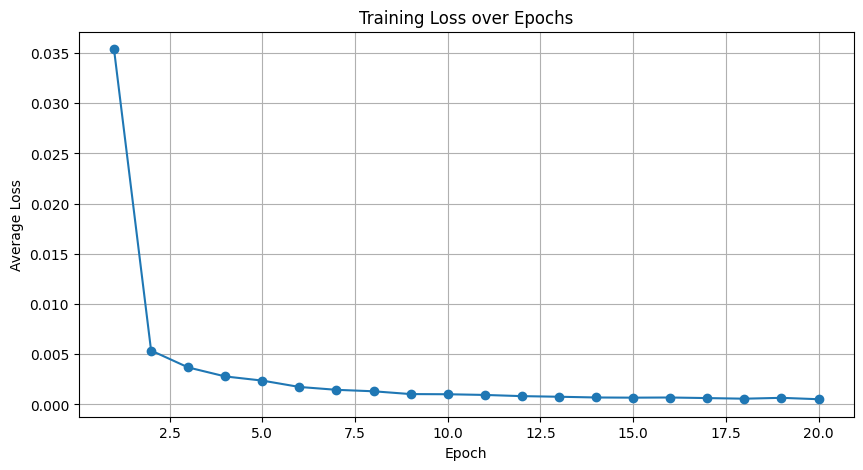

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

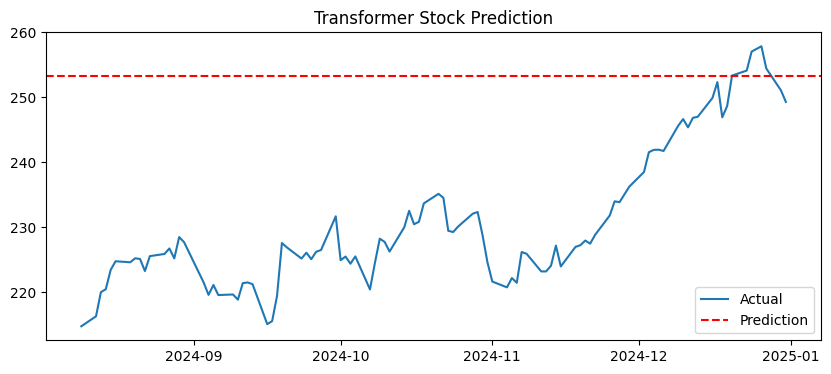

In [38]:
plt.figure(figsize=(10,4))
plt.plot(df.index[-100:], df['Close'].values[-100:], label="Actual")
plt.axhline(next_price, color="red", linestyle="--", label="Prediction")
plt.legend()
plt.title("Transformer Stock Prediction")
plt.show()


In [29]:
from huggingface_hub import login
login()


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_id = "meta-llama/Meta-Llama-3-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_id)

llama = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    load_in_4bit=True,
    torch_dtype=torch.float16
)


In [ ]:
prompt = f"""
Stock: {ticker}
Last Price: {last_price}
Predicted Price: {next_price}
RMSE: {rmse}

Explain trend, risk, confidence, and give Buy/Sell/Hold.
"""

inputs = tokenizer(prompt, return_tensors="pt").to(llama.device)

with torch.no_grad():
    output = llama.generate(
        **inputs,
        max_new_tokens=200,
        temperature=0.6
    )

print(tokenizer.decode(output[0], skip_special_tokens=True))
